In [69]:
import anndata 
import pandas as pd
import scanpy as sc
import pybedtools
import numpy as np
from ALLCools.plot import categorical_scatter,continuous_scatter
import matplotlib.pyplot as plt
from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
import joblib
from amb import *
from ALLCools.clustering import *
import seaborn as sns


plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

age_palette = get_age_palette()
age_palette['8wk'] = age_palette['2mo']

ct_palette = joblib.load('/home/qzeng_salk_edu/project/240319_te/AgingMajorType_Palette')
# replace the keys by .apply(lambda x: x.replace(' ','_').replace('/',''))
ct_palette = {x.replace(' ','_').replace('/',''):y for x,y in ct_palette.items()}

region_palette = get_major_region_palette()

In [53]:
inout = 'out20'
te_class ='LINE'
age_order = ['8wk','9mo','18mo']
genomepath = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
gene_bed = pybedtools.BedTool('/home/qzeng_salk_edu/project/241115_te_clustering/TE_use.gencode.vM22.annotation.gene.sorted.bed')
te_bed = pybedtools.BedTool(f'/ref/repeatmasker-with-id/hg38.repeatmasker.repClass-{te_class}.bed')

In [11]:
if inout=='out20':
    feats = te_bed.subtract(gene_bed.flank(b=20000, g=genomepath)).to_dataframe()['name'].tolist()
elif inout=='out10':
    feats = te_bed.subtract(gene_bed.flank(b=10000, g=genomepath)).to_dataframe()['name'].tolist()
elif inout=='out2':
    feats = te_bed.subtract(gene_bed.flank(b=2000, g=genomepath)).to_dataframe()['name'].tolist()
elif inout=='out':
    feats = te_bed.subtract(gene_bed).to_dataframe()['name'].tolist()
elif inout=='in':
    feats = te_bed.intersect(gene_bed,).to_dataframe()['name'].tolist()
else:
    feats = te_bed.to_dataframe()['name'].tolist()

In [106]:
adata_path = '/home/qzeng_salk_edu/project/241115_te_clustering/plot_LINE_by_ct/DG_Glut/clustered.DG_Glut.LINE.h5ad'
adata = anndata.read_h5ad(adata_path)
# select faetures
shared_feats = list(set(feats) & set(adata.var_names))
adata = adata[:,shared_feats].copy()

adata.obs['Region.Age'] = adata.obs['Region'].astype(str) + '.' + adata.obs['Age'].astype(str)
# sleect plot_regions  = ['Anterior_Hippocampus','Posterior_Hippocampus']
plot_regions  = ['Anterior_Hippocampus','Posterior_Hippocampus']
adata = adata[adata.obs['Region'].isin(plot_regions),:].copy()
adata

AnnData object with n_obs × n_vars = 4765 × 546795
    obs: 'celltype', 'Age', 'Region', 'hypo_te_counts', 'out20_leiden', 'out2_leiden', 'out_leiden', 'all_leiden', 'in_leiden', 'Region.Age'
    obsm: 'X_all_tsne', 'X_in_tsne', 'X_out20_tsne', 'X_out2_tsne', 'X_out_tsne'

In [98]:
# #regions in Anterior_Hippocampus
# region = 'Anterior_Hippocampus'
# adata = adata[adata.obs['Region']==region].copy()

In [107]:
hypo_counts = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
hypo_counts['Region.Age'] = adata.obs['Region.Age']
# 
hypo_counts_mean = hypo_counts.groupby('Region.Age').mean()
# select the top 300 column thet has the highst std and mean change amoung age groups 
top_feats = hypo_counts_mean.std(axis=0).sort_values(ascending=False).index[:500]


In [108]:
leg = [f"{region}.{age}"  for region in plot_regions for age in age_order]
leg

['Anterior_Hippocampus.8wk',
 'Anterior_Hippocampus.9mo',
 'Anterior_Hippocampus.18mo',
 'Posterior_Hippocampus.8wk',
 'Posterior_Hippocampus.9mo',
 'Posterior_Hippocampus.18mo']

In [109]:
toplot = hypo_counts_mean[top_feats].T[leg]
# normalize by rows
#toplot = toplot.div(toplot.sum(axis=1), axis=0)
toplot.head()

Region.Age,Anterior_Hippocampus.8wk,Anterior_Hippocampus.9mo,Anterior_Hippocampus.18mo,Posterior_Hippocampus.8wk,Posterior_Hippocampus.9mo,Posterior_Hippocampus.18mo
LINE,,,,,,
LINE.280760,0.443808,0.513295,0.709468,0.503597,0.520947,0.545455
LINE.178251,0.362205,0.387283,0.531777,0.253597,0.371585,0.379585
LINE.183255,0.290623,0.314451,0.380026,0.181655,0.182149,0.208931
LINE.498843,0.392985,0.473988,0.601816,0.426259,0.460838,0.503987
LINE.425827,0.435218,0.519075,0.579767,0.399281,0.420765,0.425837


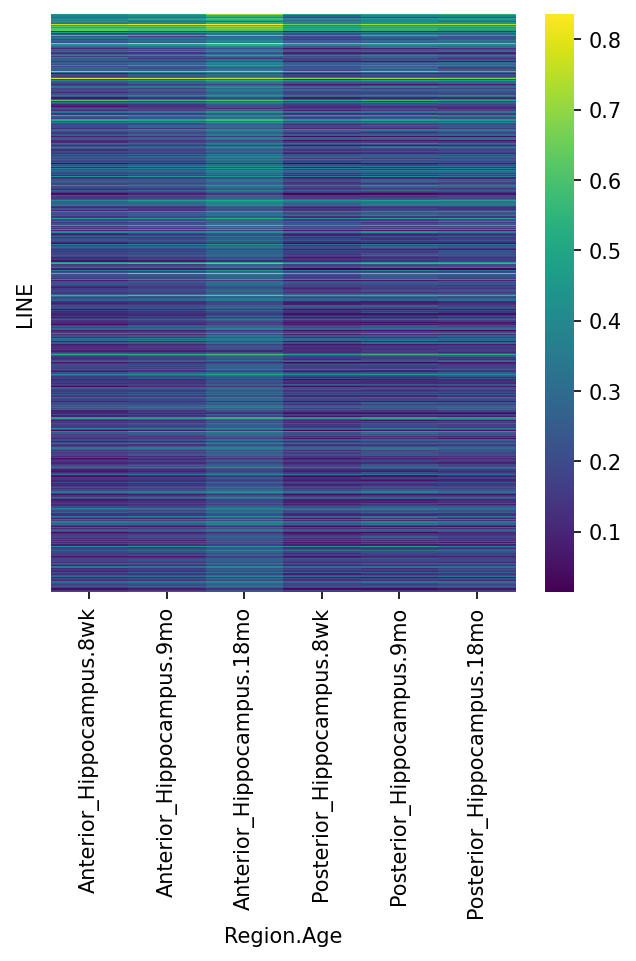

In [110]:
# use sns to plot the heatmap
fig, ax = plt.subplots(figsize=(5,5), dpi = 150)
sns.heatmap(toplot, 
            cmap='viridis', 
            #vmin = 0.1, vmax =0.5,
            rasterized=True,
            yticklabels=True)
# do not plot the ylabels
plt.yticks([])

plt.show()


'LINE.280760'